In [1]:
import json
import re
import numpy as np
import cv2
# darkflow expect each image comes with one annotation file in the format of 
# [category number] [object center in X] [object center in Y] [object width in X] [object width in Y]
# We need to convert our annotation file into that format
# In our annotation file［box_upper_left_x, box_upper_left_y, box_lower_right_x, box_lower_right_y, class_label]


output_dir = 'training/'
input_file1 = "./sub_training/comb-label_left.idl"
input_file2 = "./sub_training/comb-label_right.idl"
with open(input_file1) as f:
    lines1 = f.readlines()
with open(input_file2) as f:
    lines2 = f.readlines()

boxes = {1:[],2:[],3:[],20:[]}
cnt = [0,0,0,0]  # counting for each classes
    
for each in lines1:
    line = json.loads(each)  
    if not list(line.values())[0]: # no annotation for this image
        continue
    else:
        for box in list(line.values())[0]:
            label = box[4]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            msg = [xmin,xmax,ymin,ymax]
            boxes[label].append(msg)
# check statistics for new left
#for box in boxes.values():
#    print(len(box))
    

for each in lines2:
    line = json.loads(each)  
    if not list(line.values())[0]: # no annotation for this image
        continue
    else:
        for box in list(line.values())[0]:
            label = box[4]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            msg = [xmin,xmax,ymin,ymax]
            boxes[label].append(msg)

idx = 0            
for box in boxes.values(): 
    #print(len(box))
    cnt[idx] = len(box)
    idx = idx+1

In [18]:
boxes

{1: [[54.16640000000001, 101.00031999999999, 192.99996, 224.83332000000001],
  [0, 64.0, 160.49988, 267.4998],
  [11.333120000000008,
   83.83359999999999,
   188.49996000000002,
   240.66647999999998],
  [99.66656, 125.33312000000001, 181.16676, 210.83327999999997],
  [7.832960000000014, 34.83328, 196.3332, 219.6666],
  [0, 22.16640000000001, 200.00016000000002, 218.16683999999998],
  [33.500159999999994, 55.25056000000001, 200.75004, 217.00008000000003],
  [130.99968, 312.33344, 145.6668, 264.83328],
  [0, 32.0, 197.49996, 220.83336],
  [74.16640000000001, 100.0, 198.16668, 216.50003999999998],
  [37.33312000000001, 71.00031999999999, 192.33324000000002, 222.66684],
  [143.33312, 172.16704, 196.49988000000002, 215.83332],
  [264.99968, 477.83360000000005, 49.16664, 355.16664],
  [46.167039999999986, 72.33344, 200.33316, 221.66675999999998],
  [22.499840000000006, 79.66656, 190.00008, 239.83344],
  [95.16672, 134.49984, 197.33328, 226.33344000000002],
  [224.99968, 314.33344, 195.8331

In [2]:
# boxes = {1:[],2:[],3:[],20:[]}
for each in boxes.keys():
    print(each)
for each in boxes.values():
    print(each)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
def get_width(box):
    return box[1]-box[0]
def get_height(box):
    return box[3]-box[2]


In [4]:
box_shape = list()
for box in boxes.values(): 
    for each in box:
        w = get_width(each)
        h = get_height(each)
        box_shape.append([w,h])

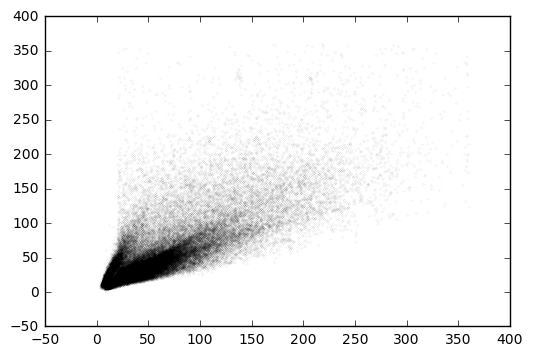

In [5]:
# boxes with width and height
import matplotlib.pyplot as plt
%matplotlib inline 

plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')

In [6]:
'''
Created on Feb 20, 2017

@author: jumabek
'''
from os import listdir
from os.path import isfile, join
import argparse
import cv2
import numpy as np
import sys
import os
import shutil
import random 
import math
import json

width_in_cfg_file = 416.
height_in_cfg_file = 416.

def IOU(x,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_w,c_h = centroid
        w,h = x
        if c_w>=w and c_h>=h:
            similarity = w*h/(c_w*c_h)
        elif c_w>=w and c_h<=h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w<=w and c_h>=h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n

def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    for i in range(anchors.shape[0]):
        anchors[i][0]*=width_in_cfg_file/32.
        anchors[i][1]*=height_in_cfg_file/32.
         

    widths = anchors[:,0]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.2f,%0.2f, '%(anchors[i,0],anchors[i,1]))

    #there should not be comma after last anchor, that's why
    f.write('%0.2f,%0.2f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))

def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))

    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        
        print ("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
            
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        
        #if (assignments == prev_assignments).all() :
        #    print("Centroids = ",centroids)            
        #    write_anchors_to_file(centroids,X,anchor_file)
        #    return

        if (assignments == prev_assignments).all() :
            print("Centroids = ",centroids)            
            return centroids
        
        #calculate new centroids
        centroid_sums=np.zeros((k,dim),np.float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):            
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j))
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()  



In [7]:
# Running K-means
num_clusters = 5
eps = 0.005
box_shape = np.array(box_shape)
anchor_file = 'anchors.txt'
indices = [ random.randrange(box_shape.shape[0]) for i in range(num_clusters)]
centroids = box_shape[indices] # randomly initialized the centroid to elements in the set
centroids = kmeans(box_shape,centroids,eps,anchor_file) # result is not saved in file, instead print on screen

iter 1: dists = 218727.3143146789
iter 2: dists = 34769.67266941888
iter 3: dists = 15425.635973548575
iter 4: dists = 9524.982736815966
iter 5: dists = 7441.082513626642
iter 6: dists = 6398.6918310353185
iter 7: dists = 5547.571132652801
iter 8: dists = 4945.330444375318
iter 9: dists = 4368.590744924339
iter 10: dists = 3705.7611250448294
iter 11: dists = 3148.7619203692184
iter 12: dists = 2807.0733514675335
iter 13: dists = 2443.0058630113313
iter 14: dists = 2135.815174504416
iter 15: dists = 1802.1764983635978
iter 16: dists = 1601.7695857866124
iter 17: dists = 1400.5264032965151
iter 18: dists = 1164.969347815266
iter 19: dists = 1075.2702634200957
iter 20: dists = 883.3342164457442
iter 21: dists = 767.482425129275
iter 22: dists = 633.7657468131629
iter 23: dists = 554.5787084010575
iter 24: dists = 487.73931693536935
iter 25: dists = 445.5166306240306
iter 26: dists = 390.6243067281655
iter 27: dists = 400.6839333552849
iter 28: dists = 321.33386353770237
iter 29: dists = 2

averge IOU is 0.6151644347649192
Anchors =  [[0.54772542 0.60795297]
 [1.24203594 1.1330562 ]
 [2.27821192 1.69218289]
 [3.22386949 3.22392679]
 [5.66950174 4.92887942]]


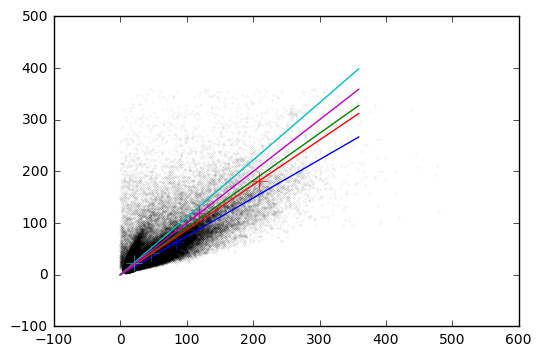

In [17]:
# These runs are for crop 480, useless now
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# For 416x416 images anchor box should be between [0 to 13], because 416/32 = 13
img_width = 480
img_height = 480
width_in_cfg_file = 416
anchors_run1 = np.array([[ 84.11859391, 62.48059889],
 [ 45.85978864,  41.8359212 ],
 [209.33544883, 181.98939407],
 [ 20.22370778,  22.44749422],
 [119.03518113, 119.03729681]])

print('averge IOU is {}'.format(avg_IOU(np.asarray(box_shape),anchors_run1)))

f = plt.figure()
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')
X = list(range(360))
for i in range(anchors_run1.shape[0]):
    plt.plot(X, np.multiply(X,1.*anchors_run1[i][1]/anchors_run1[i][0]),color = c[i])
    plt.plot(anchors_run1[i][0],anchors_run1[i][1], markersize=12 , marker = '+', color = c[i])

for i in range(anchors_run1.shape[0]):
    anchors_run1[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run1[i][1]*=width_in_cfg_file/480.
    anchors_run1[i][0]/=32. 
    anchors_run1[i][1]/=32.
# print(sorted(anchors_run1, key = lambda x: x[1])) 

widths = anchors_run1[:,0]
sorted_indices = np.argsort(widths)

print('Anchors = ', anchors_run1[sorted_indices])

In [85]:
# These runs are for crop 480, useless now
anchors_run2 = np.array([[136.51134673, 111.27001078],
 [ 78.669171,    75.00685743],
 [ 47.89625292, 38.61094355],
 [ 20.05567117,  22.84915965],
 [204.05708251, 191.71262056]])
for i in range(anchors_run1.shape[0]):
    anchors_run2[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run2[i][1]*=width_in_cfg_file/480.
    anchors_run2[i][0]/=32. 
    anchors_run2[i][1]/=32.
widths = anchors_run2[:,0]
sorted_indices = np.argsort(widths)

print('Anchors = ', anchors_run2[sorted_indices])

[[3.69718231 3.01356279]
 [2.13062338 2.03143572]
 [1.29719018 1.04571305]
 [0.54317443 0.61883141]
 [5.52654598 5.19221681]]


averge IOU is 0.6874085626376437
Anchors =  [[0.39788518 0.51267565]
 [0.64116229 2.00708268]
 [0.8582806  0.67417279]
 [1.40511672 1.01954274]
 [1.78326528 3.96075677]
 [2.07484186 1.57227249]
 [3.15946796 2.31490638]
 [4.50985573 3.6472283 ]
 [5.95163536 5.79801817]]


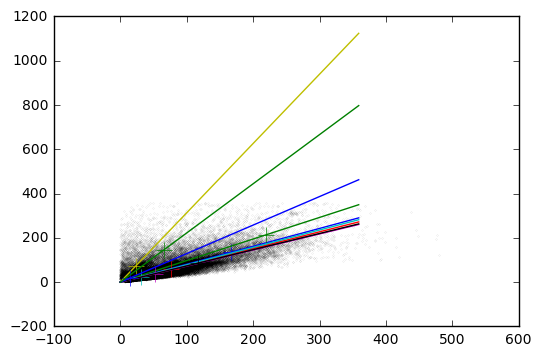

In [18]:
import numpy as np
# For 416x416 images anchor box should be between [0 to 13], because 416/32 = 13
img_width = 480
img_height = 480
width_in_cfg_file = 416
anchors_run3 = np.array([[166.51774989, 134.66689102],
 [219.75269009, 214.08067085],
 [ 76.6095457,   58.05313821],
 [ 31.69036079,  24.89253361],
 [ 51.88123273,  37.64465494],
 [ 23.67368465,  74.10766804],
 [116.65727864,  85.47346639],
 [ 14.69114508,  18.92956259],
 [ 65.84364105, 146.24332675]])

print('averge IOU is {}'.format(avg_IOU(np.asarray(box_shape),anchors_run3))) 

import matplotlib.pyplot as plt
%matplotlib inline 
f = plt.figure()
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k','b','g','r','c']
plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')
X = list(range(360))
for i in range(anchors_run3.shape[0]):
    plt.plot(X, np.multiply(X,1.*anchors_run3[i][1]/anchors_run3[i][0]),color = c[i]) # slope 
    plt.plot(anchors_run3[i][0],anchors_run3[i][1], markersize=12 , marker = '+', color = c[i]) #centroid

    # The anochor value put in cofigure file if the input image is resized to width_in_cfg_file
for i in range(anchors_run3.shape[0]):
    anchors_run3[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run3[i][1]*=width_in_cfg_file/480.
    anchors_run3[i][0]/=32. 
    anchors_run3[i][1]/=32.
# print(sorted(anchors_run3, key = lambda x: x[1]))    
widths = anchors_run3[:,0]
sorted_indices = np.argsort(widths)

print('Anchors = ', anchors_run3[sorted_indices])

averge IOU is 0.6215357174910965
Anchors =  [[0.73760829 0.75110065]
 [1.47805514 3.51541271]
 [1.75040768 1.34067177]
 [3.5183695  2.65420198]
 [6.2126083  5.78690696]]


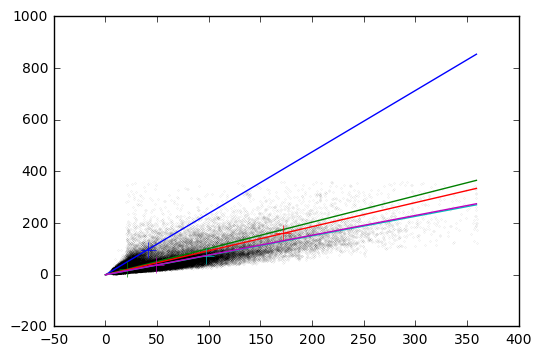

In [9]:
# These runs are for crop 480, useless now
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# For 416x416 images anchor box should be between [0 to 13], because 416/32 = 13
img_width = 360
img_height = 360
width_in_cfg_file = 416
anchors_run1 = np.array([[ 40.93075759,  97.34989046],
 [ 20.42607583,  20.79971041],
 [172.04146066, 160.25280818],
 [ 97.43177076,  73.5009779 ],
 [ 48.47282798,  37.12629507]]
)

print('averge IOU is {}'.format(avg_IOU(np.asarray(box_shape),anchors_run1)))

f = plt.figure()
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')
X = list(range(360))
for i in range(anchors_run1.shape[0]):
    plt.plot(X, np.multiply(X,1.*anchors_run1[i][1]/anchors_run1[i][0]),color = c[i])
    plt.plot(anchors_run1[i][0],anchors_run1[i][1], markersize=12 , marker = '+', color = c[i])

for i in range(anchors_run1.shape[0]):
    anchors_run1[i][0]*=1.*width_in_cfg_file/img_width # rescale to input images size 416
    anchors_run1[i][1]*=1.*width_in_cfg_file/img_height
    anchors_run1[i][0]/=32. 
    anchors_run1[i][1]/=32.
# print(sorted(anchors_run1, key = lambda x: x[1])) 

widths = anchors_run1[:,0]
sorted_indices = np.argsort(widths)

print('Anchors = ', anchors_run1[sorted_indices])

In [11]:
for each in boxes.values():
    print(each)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
indices = [ random.randrange(box_shape.shape[0]) for i in range(num_clusters)]
print(indices)

[2228, 62600, 20298, 15458, 61691]
